# Model Definition

In [1]:
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.applications.vgg16 import preprocess_input
import numpy as np

In [2]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Input

vgg_feature_model = VGG16(
    weights="imagenet", 
    include_top=False, 
    input_tensor=Input((256,256,3))
)

In [3]:
def conv_block(x, num_filters):
  x = layers.Conv2D(num_filters, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  x = layers.Conv2D(num_filters, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation("relu")(x)

  return x

In [4]:
def encoder_block(x, num_filters):
  x = conv_block(x, num_filters)
  p = layers.MaxPool2D((2,2))(x)
  return x, p

In [5]:
def decoder_block(x, skip_features, num_filters):
  x = layers.Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(x)
  x = layers.Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

In [6]:
x = tf.random.normal((3,256,256,3))
x = vgg_feature_model(x)

print(x.shape)

(3, 8, 8, 512)


In [7]:
def build_unet(feature_model):
  head = feature_model.output
  x = layers.Conv2DTranspose(filters=256, kernel_size=3, strides=2)(head)
  x = layers.Conv2DTranspose(filters=128, kernel_size=3, strides=2)(x)
  x = layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2)(x)
  x = layers.Conv2DTranspose(filters=32, kernel_size=3, strides=2)(x)
  x = layers.Conv2DTranspose(filters=16, kernel_size=3, strides=2)(x)
  x = layers.Conv2DTranspose(filters=8, kernel_size=3, strides=2)(x)
  x = layers.Conv2D(filters=3, kernel_size=3, strides=2)(x)
  inputs = tf.image.resize(x, (256,256))

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  bridge = conv_block(p4, 1024)

  d3 = decoder_block(bridge, s4, 512)
  d2 = decoder_block(d3, s3, 256)
  d1 = decoder_block(d2, s2, 128)
  d0 =  decoder_block(d1, s1, 64)

  outputs = layers.Conv2D(1, 1, padding="same", activation="sigmoid")(d0)

  return tf.keras.Model(feature_model.input, outputs)

model = build_unet(vgg_feature_model)

In [8]:
x = tf.random.normal((3,256,256,3))
print(model(x).shape)

(3, 256, 256, 1)


# Dataset

In [9]:
import cv2
import os
import numpy as np
from PIL import Image

In [10]:
autotune = tf.data.experimental.AUTOTUNE
img_size = 256
buffer_size = 256
batch_size = 16

In [11]:
def path_to_imgMask(file_path):
  return file_path

def path_to_imgLabel(file_path):
  mask_filepath = tf.strings.regex_replace(file_path, "cars", "masks" )
  mask_filepath = tf.strings.regex_replace(mask_filepath, ".jpg", "_mask.gif" )

  img = tf.io.read_file(file_path)
  img = tf.image.decode_jpeg(img)
  img = tf.cast(tf.image.resize(img, (img_size, img_size)), dtype=tf.uint8)

  mask = tf.io.read_file(mask_filepath)
  mask = tf.image.decode_gif(mask)
  mask = mask[0, ...]
  mask = tf.image.resize(mask, (img_size, img_size))
  mask = tf.reduce_mean(mask, axis=-1,keepdims=True)/255
  mask = tf.cast(tf.where(tf.less_equal(mask, 0.5), 0, 1), dtype=tf.uint8)
  print("mask.shape", mask.shape)
  return img, mask

def preprocess_train_image(img, mask):
  img = tf.cast(img, dtype=tf.float32)/255.0
  return img, mask

In [12]:
from functools import partial

from albumentations import (
  Compose,
  CenterCrop,
  PadIfNeeded,
  RandomBrightnessContrast,
  ImageCompression,
  HueSaturationValue, 
  HorizontalFlip,
  Rotate
)

transforms_color_invariant = Compose(
  [
    Rotate(limit=40),
    HorizontalFlip(),
  ],
  additional_targets={'mask0': 'image'}
)

transform_color = Compose(
  [
    RandomBrightnessContrast(p=0.5),
    ImageCompression(quality_lower=85, quality_upper=100, p=0.5),
    HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
  ]
)

# target "mask0" will adopt the same set of transformations as "image"

def aug_color_invariant_fn(image, mask):
  transformed = transforms_color_invariant(image=image, mask0=mask)
  image = transformed['image']
  mask = transformed['mask0']
  return image, mask

def aug_color_fn(image, mask):
  aug_data = transform_color(image=image)
  image = aug_data['image']
  return image, mask

def aug_color_invariant(image, mask):
  transformed = tf.numpy_function(func=aug_color_invariant_fn, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
  aug_img = transformed[0]
  aug_mask = transformed[1]
  aug_img.set_shape((img_size, img_size, 3))
  aug_mask.set_shape((img_size, img_size, 1))

  return aug_img, aug_mask
   
  
def aug_color(image, mask):
  transformed = tf.numpy_function(func=aug_color_fn, inp=[image, mask], Tout=[tf.uint8, tf.uint8])
  aug_img = transformed[0]
  aug_mask = transformed[1]
  aug_img.set_shape((img_size, img_size, 3))
  aug_mask.set_shape((img_size, img_size, 1))

  return aug_img, aug_mask


In [13]:
dataset = tf.data.Dataset.list_files("./cars/*") 

train_data = dataset.take(4070) \
.map(path_to_imgLabel) \
.map(aug_color_invariant) \
.map(aug_color) \
.map(preprocess_train_image) \
.shuffle(buffer_size) \
.batch(batch_size) \

val_data = dataset.skip(4070) \
.map(path_to_imgLabel) \
.map(aug_color_invariant) \
.map(preprocess_train_image) \
.shuffle(buffer_size) \
.batch(batch_size) 


mask.shape (256, 256, 1)
mask.shape (256, 256, 1)


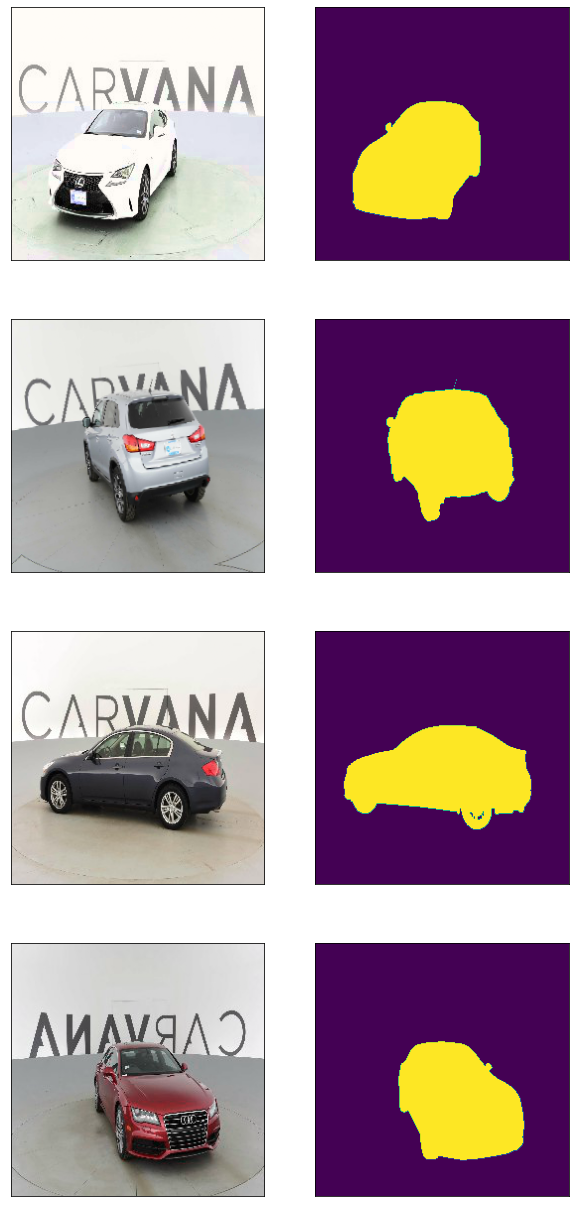

In [14]:
# check the data: 

import matplotlib.pyplot as plt
import re 

fig = plt.figure(figsize=(10, 22))

for batch in train_data.take(1):
  img, mask = batch
  imgs = img.numpy()[0:4]
  masks = mask.numpy()[0:4]

  for i, (img, mask) in enumerate(zip(imgs, masks)):
    ax = fig.add_subplot(4, 2, 2*i+1, xticks=[], yticks=[])
    ax.imshow(img)
    ax = fig.add_subplot(4, 2, 2*i+2, xticks=[], yticks=[])
    ax.imshow(mask)


# Training

In [15]:
from tensorflow.keras.callbacks import Callback

class EpochCheckpoint(Callback):
    def __init__(self, output_dir, step=1 , every=1, startAt=0, model_title="car-segmentation"):
        super(Callback, self).__init__()
        self.step = step
        self.output_dir = output_dir
        self.every = every
        self.intEpoch = startAt
        self.model_title = model_title

    def on_epoch_end(self, epoch, logs={}):
        if (self.intEpoch + 1) % self.every == 0:
            p = os.path.sep.join([self.output_dir, self.model_title + "epoch-{}-{}.hdf5".format(self.step, self.intEpoch + 1)])
            self.model.save(p, overwrite=True)

        self.intEpoch += 1

In [16]:
from tensorflow.keras.callbacks import BaseLogger
import matplotlib.pyplot as plt
import numpy as np
import json
import os
import tensorflow.keras.backend as K

class TrainingMonitorCallback(BaseLogger):
    def __init__(self, fig_dir, step=1, jsonPath=None, startAt=0):
        super(TrainingMonitorCallback, self).__init__()
        self.fig_dir = fig_dir
        self.jsonPath = jsonPath
        self.startAt = startAt
        self.step=step

    def on_train_begin(self, logs={}):
        self.H = {}
        if self.jsonPath is not None:
            if os.path.exists(self.jsonPath):
                self.H = json.loads(open(self.jsonPath).read())

                if self.startAt > 0:
                    for k in self.H.keys():
                        self.H[k] = self.H[k][:self.startAt]

    def on_epoch_end(self, epoch, logs={}):
        print("[INFO] learning rate: {}".format(K.get_value(self.model.optimizer.lr)))
        for (k, v) in logs.items():
            l = self.H.get(k, [])
            l.append(float(v))
            self.H[k] = l

        if self.jsonPath is not None:
            f = open(self.jsonPath, "w")
            f.write(json.dumps(self.H, indent=4))
            f.close()

        if len(self.H["loss"]) > 0:
            epoch = len(self.H["loss"])
            N = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            _, ax1 = plt.subplots()
            l1, = ax1.plot(N, self.H["loss"], label="train_loss",  color="olive")
            l2, = ax1.plot(N, self.H["val_loss"], label="val_loss", color="red")
            ax2 = ax1.twinx()
            l3, = ax2.plot(N, self.H["accuracy"], label="train_acc", color="royalblue")
            l4, = ax2.plot(N, self.H["val_accuracy"], label="val_acc", color="midnightblue")
            plt.title("Training Loss and Accuracy [Epoch {}]".format(len(self.H["loss"])))
            plt.xlabel("Epoch #")
            plt.ylabel("Loss/Accuracy")
            
            plt.legend([l1,l2,l3,l4], ["train_loss", "val_loss", "train_acc", "val_acc"], loc='lower left')

            # save the figure
            plt.savefig(f"{self.fig_dir}/epoch-{self.step}-{epoch}.png")
            plt.close()

In [17]:
callbacks = [
  EpochCheckpoint(output_dir="./checkpoints"),
  TrainingMonitorCallback(
    fig_dir="./checkpoints-figure", 
    jsonPath="./checkpoints-json/loss.json"
  )
]

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
  loss="binary_crossentropy",
  metrics=["accuracy"]
)

In [31]:
for layer in vgg_feature_model.layers:
  layer.trainable = False

In [32]:
model.fit(
  train_data,
  steps_per_epoch=len(train_data),
  epochs=5,
  validation_data=val_data,
  validation_steps=len(val_data),
  callbacks=callbacks
)

Epoch 1/5
255/255 [==============================] - 180s 666ms/step - loss: 0.2624 - accuracy: 0.8939 - val_loss: 0.5172 - val_accuracy: 0.7890
[INFO] learning rate: 9.999999747378752e-05
Epoch 2/5
255/255 [==============================] - 170s 649ms/step - loss: 0.0695 - accuracy: 0.9872 - val_loss: 0.1155 - val_accuracy: 0.9627
[INFO] learning rate: 9.999999747378752e-05
Epoch 3/5
255/255 [==============================] - 170s 649ms/step - loss: 0.0492 - accuracy: 0.9903 - val_loss: 0.0393 - val_accuracy: 0.9915
[INFO] learning rate: 9.999999747378752e-05
Epoch 4/5
255/255 [==============================] - 170s 650ms/step - loss: 0.0391 - accuracy: 0.9914 - val_loss: 0.0329 - val_accuracy: 0.9921
[INFO] learning rate: 9.999999747378752e-05
Epoch 5/5
255/255 [==============================] - 170s 650ms/step - loss: 0.0318 - accuracy: 0.9924 - val_loss: 0.0256 - val_accuracy: 0.9938
[INFO] learning rate: 9.999999747378752e-05


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [19]:
for layer in vgg_feature_model.layers:
  layer.trainable = True

In [20]:
from tensorflow.keras.models import load_model

prev_model_path = "./checkpoints/car-segmentationepoch-1-5.hdf5"
start_at_epoch = 5
new_lr = 1e-4
step = 2

model = load_model(prev_model_path)
print("[INFO] step: {}, start at epoch: {}".format(step, start_at_epoch))
print("[INFO] old learning rate: {}".format(K.get_value(model.optimizer.lr)))
K.set_value(model.optimizer.lr, new_lr)
print("[INFO] new learning rate: {}".format(K.get_value(model.optimizer.lr)))

callbacks = [
  EpochCheckpoint(output_dir="./checkpoints", step=step, startAt=start_at_epoch),
  TrainingMonitorCallback(
    fig_dir="./checkpoints-figure", 
    jsonPath="./checkpoints-json/loss.json",
    startAt=start_at_epoch,
    step=step
  )
]

model.fit(
  train_data,
  steps_per_epoch=len(train_data),
  epochs=1,
  validation_data=val_data,
  validation_steps=len(val_data),
  callbacks=callbacks
)

[INFO] step: 2, start at epoch: 5
[INFO] old learning rate: 9.999999747378752e-05
[INFO] new learning rate: 9.999999747378752e-05
255/255 [==============================] - 186s 689ms/step - loss: 0.0261 - accuracy: 0.9931 - val_loss: 0.0248 - val_accuracy: 0.9928
[INFO] learning rate: 9.999999747378752e-05


<Figure size 432x288 with 0 Axes>

# Test the Model

In [22]:
import cv2
import os
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import random
import numpy as np

In [26]:
model = load_model("./checkpoints/car-segmentationepoch-2-6.hdf5")

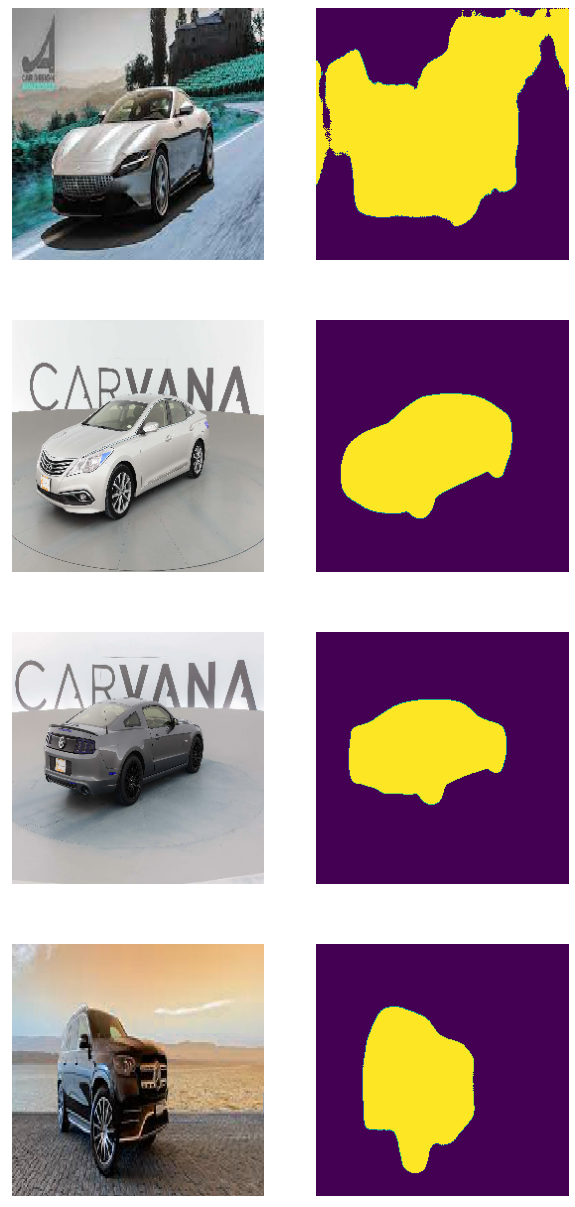

In [36]:
test_dir = "./test_samples"

image_names = os.listdir(test_dir)
random.shuffle(image_names)
image_names = image_names[0:4]

fig = plt.figure(figsize=(10, 22))

images = []

for img_name in image_names:
  file_path = f"{test_dir}/{img_name}"
  img = cv2.imread(file_path)
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_NEAREST)
  img = img/255.0
  images.append(img)

images = np.array(images)
masks = model.predict(images)
masks = np.where(masks < 0.5, 0, 255)

for i, (img, mask) in enumerate(zip(images, masks)):
  ax = fig.add_subplot(4, 2, 2*i+1, xticks=[], yticks=[])
  ax.imshow(img)
  ax = fig.add_subplot(4, 2, 2*i+2, xticks=[], yticks=[])
  ax.imshow(mask)